In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path


import matplotlib.pyplot as plt
import matplotlib

import theano
import theano.tensor as tt
import pymc3 as pm
theano.config.optimizer="fast_run"

In [2]:
path.append("../src")
import Bernstein
import Population
import Cases

In [3]:
#Bernstein.Bernstein(4,16).eval()

# Import SurvStat BL weekly cases
with open("../Data/Cases/SurvStat_RKI/lks_210219.pickle","br") as f:
    cases = Cases.ParseSurvStatDay_BL(pickle.load(f))


In [4]:
# Read Population Data for @destatis per BL, extrapolate population for each week
pop = Population.ImportPopulation()

weeks = range(1,66)
wpop = Population.WeeklyPopulation(pop,weeks)

{0: '31.12.2019', 53: '31.12.2020', 105: '31.12.2021', 157: '31.12.2022'}


2020-11-17 00:00:00 weekly rows Altersverteilung_201117.csv
2020-11-10 00:00:00 weekly rows Altersverteilung_201110.csv


Coordinates:
  * week         (week) int64 10 11 12 13 14 15 16 17 ... 53 54 55 56 57 58 59
  * age          (age) int64 90 85 80 75 70 65 60 55 ... 35 30 25 20 15 10 5 0
    publication  datetime64[ns] 2021-02-09

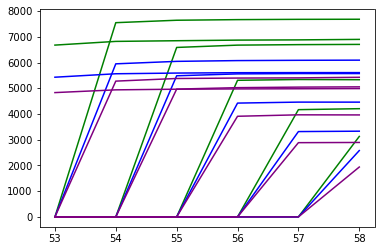

In [5]:
# weekly 5y age groups up to 80-84,85-89,90+ for geramny + sex

age_cases10y,age_cases5y = Cases.RKI_Altersverteilung()

compare = age_cases5y.sel({"age":[80,85,90],"week":range(53,59),"publication":[datetime.datetime(2021,2,9),datetime.datetime(2021,2,2),datetime.datetime(2021,1,26),datetime.datetime(2021,1,19),datetime.datetime(2021,1,12),datetime.datetime(2021,1,5)][::-1]})
for c,age in zip(["green","blue","purple"],compare.get_index("age")):
    plt.plot(compare.get_index("week"),compare.sel(age=age).transpose("publication","week"),color=c)

age_cases5y = age_cases5y.sel(publication=datetime.datetime(2021,2,9))

age_cases5y.coords

In [13]:
def Decompose_80plus_Population(age_dist):
    """
        b_component,"sex","age","BL","week"
    """
    bernstein_weights = Bernstein.Bernstein(2,21).dimshuffle(0,'x',1,'x','x')
    
    return bernstein_weights*age_dist[...,80:,:,:]

def Generate_80plus_Cases_Factors(b0,b1,b2):
    
  #  b1 = pm.Lognormal("80plus/90")
  #  b2 = pm.Lognormal("80plus/100")
    
    b1 = pm.Lognormal("80plus/90",tt.log(b1),dims=["sex","BL"],dytpe="float64")
    b2 = pm.Lognormal("80plus/100",tt.log(b2),dims=["sex","BL"],dtype="float64")
    b0 = tt.ones_like(b1) * b0
    
    # b by sex,BL,week
    b = tt.ones([1,1,1,1,1]) * tt.stack([b0,b1,b2]) #.dimshuffle(0,'x','x','x','x')
    b = b.dimshuffle(2,3,1,4,0)
    
    return b

def Estimate_80plus_Cases_Simple2B(cases,age_dist,b):
    """b2 = 2nd Bernstein-coefficient, b1 might be set to an offset for age80
        "sex","age",...,"BL","week"
    """
    decompsed_age_dist = b*Decompose_80plus_Population(age_dist)
    summed_age_dist = tt.sum(decompsed_age_dist,axis=0)
    
    normalized = summed_age_dist / tt.sum(summed_age_dist,axis=1,keepdims=True)
    cases80 = cases[:,80].dimshuffle(0,'x',1,2)
    
    est_cases80 = normalized*cases80
    return tt.concatenate([cases[:,:80,...],est_cases80],axis=1)
    
 #   dpop = tt.cast(age_dist[:,80:,...],"float64").dimshuffle('x',0,1,2,3)*bernstein_weights
  #  o80pop = b0*dpop[0] + b1*dpop[1] + b2*dpop[2]
   # no80pop = 

#    return tt.concatenate([cases[:,:80,...],o80pop],axis=1),g,rpop

ct = cases.sum("category").sel(week=range(10,60),sex=["male","female"]).transpose("sex","age","BL","week")
ctt = tt.cast(ct,"float64")
print(ct.shape)
print(ct.coords)

wt = wpop.sel(week=range(10,60)).transpose("sex","age","BL","week")
print(wt.shape)

#b = Generate_Fractions(1,3,5)
#x = Estimate_80plus_Cases_Simple2B(ctt,wt,b).eval()

#x.shape

#plt.plot( (x[1,:,-1,30:40]) )

(2, 81, 16, 50)
Coordinates:
  * BL       (BL) int8 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * sex      (sex) <U7 'male' 'female'
  * age      (age) int8 0 1 2 3 4 5 6 7 8 9 10 ... 71 72 73 74 75 76 77 78 79 80
  * week     (week) int16 10 11 12 13 14 15 16 17 18 ... 52 53 54 55 56 57 58 59
(2, 101, 16, 50)


In [25]:
"""
ModelParams keeps track of coordinate-ranges for Model-internal datasets

"""


class ModelParams(object):
    def __init__(self,coords={}):
        self.coords = coords
    
class ObservedData(object):
    def __init__(self):
        pass
    
class AgeDisitribution80plus(ObservedData):
    def __init__(self,age_dist):
        super(AgeDisitribution80plus,self).__init__()
        
        self.age_dist = age_dist
        
        self.bernstein2_n21 = Bernstein.Bernstein(2,21).dimshuffle(0,'x',1,'x','x')
        self.Decompose_80plus_Population()
        
    def Decompose_80plus_Population(self):
        self.decomposed_age_dist = self.bernstein2_n21*self.age_dist[...,80:,:,:]
        return self.decomposed_age_dist

    
    def Generate_80plus_Cases_Factors(self,b0,b1,b2):
    
    
        b1 = pm.Lognormal("80plus/90",tt.log(b1),dims=["sex","BL"],dtype="float64")
        b2 = pm.Lognormal("80plus/100",tt.log(b2),dims=["sex","BL"],dtype="float64")
        b0 = tt.ones_like(b1) * b0
    
        # b by sex,BL,week
        b = tt.ones([1,1,1,1,1]) * tt.stack([b0,b1,b2]) #.dimshuffle(0,'x','x','x','x')
        b = b.dimshuffle(2,3,1,4,0)
    
        return b
    
    def Estimate(self,cases,variant="simple"):
        if variant == "simple":
            b = self.Generate_80plus_Cases_Factors(1.,2.,5.)
        
        weighted_decompsed_age_dist = b*self.decomposed_age_dist
        summed_age_dist = tt.sum(weighted_decompsed_age_dist,axis=0)
    
        normalized = summed_age_dist / tt.sum(summed_age_dist,axis=1,keepdims=True)
        cases80 = cases[:,80].dimshuffle(0,'x',1,2)
    
        est_cases80 = normalized*cases80
        return tt.concatenate([cases[:,:80,...],est_cases80],axis=1)



In [26]:
sex = pd.CategoricalIndex(["male","female"],ordered=True)
age = pd.RangeIndex(0,101)
age_80plus = pd.RangeIndex(80,101)
week = pd.RangeIndex(1,66)
bundesland = pd.RangeIndex(1,17)

delay = pd.RangeIndex(0,8)

mparams = ModelParams({"age":age,"age/rki":age[:81],"age/80plus":age_80plus,"sex":sex,"BL":bundesland,"week":week,"delay":delay})

age80p = AgeDisitribution80plus(wt)

print(age)

RangeIndex(start=0, stop=101, step=1)


In [27]:
with pm.Model(coords=mparams.coords) as model:
    
    cases_est80 = age80p.Estimate(ctt)

    pm.Deterministic("cases",cases_est80)
    
    trace = pm.sample(init="advi+adapt_diag",return_inferencedata=True,tune=100,draws=100,cores=2,chains=2)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 5900
Interrupted at 5,899 [2%]: Average Loss = 1.3817
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [80plus/100, 80plus/90]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 5 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [ ]:
trace.posterior["bernstein"][0,0].shape

In [23]:
trace.posterior["cases"][0,0].shape

(2, 101, 16, 50)

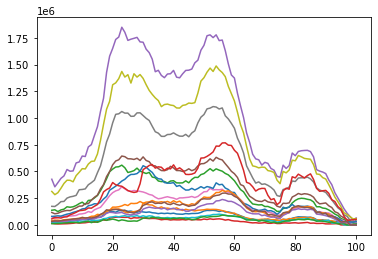

In [24]:
plt.plot( trace.posterior["cases"].sum(axis=(0,1,2,5,))[:,:] )